In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
def loadDataSet(file):
    dataSet=pd.read_table(file,header=None)
    xMat=np.mat(dataSet.iloc[:,:-1].values)
    yMat=np.mat(dataSet.iloc[:,-1].values).T
    return xMat,yMat


In [3]:
file="testSet.txt"
xMat,yMat=loadDataSet(file)

In [4]:
def showDateSet(xMat,yMat):
    data_p=[]
    data_n=[]
    m=xMat.shape[0]
    for i in range(m):
        if yMat[i]>0:
            data_p.append(xMat[i])
        else:
            data_n.append(xMat[i])
    data_p=np.array(data_p)
    data_n=np.array(data_n)
    plt.scatter(data_p.T[0],data_p.T[1])
    plt.scatter(data_n.T[0],data_n.T[1])
    plt.show()

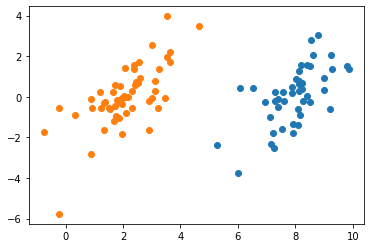

In [5]:
showDateSet(xMat,yMat)

In [6]:
#随机选择J的函数
def selectJrand(i,m):
    j=i
    while(j==i):
        j=int(np.random.uniform(0,m))
    return j

In [7]:
#边界处理  如果al大于上界 取上界  al<下界 取下界
def clipAlpha(aj,H,L):
    if aj>H:
        aj=H
    if aj<L:
        aj=L
    return aj

In [8]:
"""
C->惩罚因子
toler 容错率
maxIterax 最大迭代次数
"""
def smoSimple(xMat,yMat,C,toler,maxIter):
    b=0 #初始化b参数
    m,n=xMat.shape #m为数据集的总行数，n为特征的数量
    alpha = np.mat(np.zeros((m,1))) #初始化alpha参数，设为0
    iters =0 #初始化迭代次数
    while (iters<maxIter):
        alpha_ = 0 #初始化alpha优化次数
        for i in range(m):
            #步骤1：计算误差Ei
            fXi=np.multiply(alpha,yMat).T*(xMat*xMat[i,:].T)+b
            Ei=fXi-yMat[i]
            #优化alpha，设定容错率
            if ((yMat[i]*Ei<-toler)and(alpha[i]<C)) or((yMat[i]*Ei>toler)and(alpha[i]>0)):
            #随机选择一个与alpha_i成对优化的alpha_j
                j=selectJrand(i,m)
                #步骤1：计算误差Ej
                fXj=np.multiply(alpha,yMat).T*(xMat*xMat[j,:].T)+b
                Ej=fXj-yMat[j]
                #保存更新前的alpha_i和alpha_j
                alphaIold=alpha[i].copy()
                alphaJold=alpha[j].copy()
                #步骤2：计算上下界H和L
                if (yMat[i]!=yMat[j]):
                    L=max(0,alpha[j]-alpha[i])
                    H=min(C,C+alpha[j]-alpha[i])
                else:
                    L=max(0,alpha[j]+alpha[i]-C)
                    H=min(C,C+alpha[j]+alpha[i])
                if L==H:
                    #print('L==H')
                    continue
                #步骤3：计算学习率eta(eta是alpha_j的最优修改量)
                eta=2*xMat[i,:]*xMat[j,:].T-xMat[i,:]*xMat[i,:].T-xMat[j,:]*xMat[j,:].T
                if eta>=0:
                    #print('eta>=0')
                    continue
                #步骤4：更新alpha_j
                alpha[j]-= yMat[j]*(Ei-Ej)/eta
                #步骤5：修剪alpha_j
                alpha[j]=clipAlpha(alpha[j],H,L)
                if abs(alpha[j]-alphaJold)<0.00001:
                    #print('alpha_j 变化太小')
                    continue
                #步骤6：更新alpha_i
                alpha[i]+=yMat[j]*yMat[i]*(alphaJold-alpha[j])
                #步骤7：更新b_1和b_2
                b1=b-Ei-yMat[i]*(alpha[i]-alphaIold)*xMat[i,:]*xMat[i,:].T-yMat[j]*(alpha[j]-alphaJold)*xMat[i,:]*xMat[j,:].T
                b2=b-Ej-yMat[i]*(alpha[i]-alphaIold)*xMat[i,:]*xMat[j,:].T-yMat[j]*(alpha[j]-alphaJold)*xMat[j,:]*xMat[j,:].T
                #步骤8：根据b_1和b_2更新b
                if (0<alpha[i])and(C>alpha[i]): b=b1
                elif (0<alpha[j])and(C>alpha[j]): b=b2
                else: b=(b1+b2)/2
                #统计优化次数
                alpha_+=1
                #print(f'第{iters}次迭代 样本{i},alpha优化次数:{alpha_}')
        #更新迭代次数
        if alpha_==0: iters+=1
        else: iters=0
        #print(f'迭代次数为:{iters}')
    return b,alpha

In [9]:
%time b,alpha=smoSimple(xMat,yMat,0.6,0.001,5)

Wall time: 26.6 s


In [10]:
def get_sv(xMat,yMat,alpha):
    m=xMat.shape[0]
    sv_x=[]
    sv_y=[]
    for i in range(m):
        if alpha[i]>0:
            sv_x.append(xMat[i])
            sv_y.append(yMat[i])
    sv_x1=np.array(sv_x).T
    sv_y1=np.array(sv_y).T
    return sv_x1,sv_y1
        

In [11]:
sv_x1,sv_y1=get_sv(xMat,yMat,alpha)

In [12]:
def showPlot(xMat, yMat,alpha,b):
    data_p = [] #正样本
    data_n = [] #负样本
    m = xMat.shape[0] #样本总数
    for i in range(m):
        if yMat[i] > 0:
            data_p.append(xMat[i])
        else:
            data_n.append(xMat[i])
    data_p_ = np.array(data_p) #转换为numpy矩阵
    data_n_ = np.array(data_n) #转换为numpy矩阵
    #样本散点图
    plt.scatter(data_p_.T[0], data_p_.T[1]) #正样本散点图
    plt.scatter(data_n_.T[0], data_n_.T[1]) #负样本散点图
    #绘制支持向量
    sv_x,sv_y=get_sv(xMat,yMat,alpha)
    plt.scatter(sv_x[0], sv_x[1], s=150, c='none', alpha=0.7, linewidth=1.5,edgecolor='red')
    #绘制超平面
    w = np.dot((np.tile(np.array(yMat).reshape(1, -1).T, (1, 2)) * np.array(xMat)).T,np.array(alpha))
    a1, a2 = w
    x1 = max(xMat[:,0])[0,0]
    x2 = min(xMat[:,0])[0,0]
    b = float(b)
    a1 = float(a1[0])
    a2 = float(a2[0])
    y1, y2 = (-b- a1*x1)/a2, (-b - a1*x2)/a2
    plt.plot([x1, x2], [y1, y2])
    plt.show()

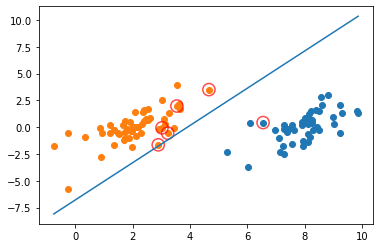

In [13]:
showPlot(xMat, yMat,alpha,b)

In [14]:
class optStruct:
    def __init__(self, xMat, yMat, C, toler):
        self.X = xMat #特征矩阵
        self.Y = yMat #数据标签
        self.C = C #松弛变量
        self.tol = toler #容错率
        self.m = xMat.shape[0] #特征矩阵行数
        self.alpha = np.mat(np.zeros((self.m,1))) #根据矩阵行数初始化alpha参数为0
        self.b = 0 #初始化b参数为0
        self.eCa = np.mat(np.zeros((self.m,2))) #根据矩阵行数初始化误差缓存，第一列为是否有效的标志位，第二列为实际误差E的值。


In [15]:
def calcEk(oS, k):
    fXk = np.multiply(oS.alpha,oS.Y).T*(oS.X*oS.X[k,:].T) + oS.b
    Ek = fXk - oS.Y[k]
    return Ek


In [16]:
"""
内循环启发方式
参数说明：
i：标号为i的数据的索引值
oS：数据结构
Ei：标号为i的数据误差
返回:
j, maxK：标号为j或maxK的数据的索引值
Ej：标号为j的数据误差
"""
def selectJ(i, oS, Ei):
    maxK = -1; maxDeltaE = 0; Ej = 0 #初始化
    oS.eCa[i] = [1,Ei] #根据Ei更新误差缓存
    eca = np.nonzero(oS.eCa[:,0].A)[0] #返回误差不为0的数据的索引值
    if (len(eca)) > 1: #有不为0的误差
        for k in eca: #遍历,找到最大的Ek
            if k == i: continue #不计算i,浪费时间
            Ek = calcEk(oS, k) #计算Ek
            deltaE = abs(Ei - Ek) #计算|Ei-Ek|
            if (deltaE > maxDeltaE): #找到maxDeltaE
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej #返回maxK,Ej
    else: #没有不为0的误差
        j = selectJrand(i, oS.m) #随机选择alpha_j的索引值
        Ej = calcEk(oS, j) #计算Ej
    return j, Ej #j,Ej


In [17]:
import os

In [18]:
file="digits/trainingDigits/"
FileList=os.listdir(file)

In [19]:
FileList[:5]

['1_0.txt', '1_1.txt', '1_10.txt', '1_100.txt', '1_101.txt']

In [20]:
def get_Mat(path):
    FileList = os.listdir(path) #提取出文件夹中所有文件的名字
    m = len(FileList) #文件个数
    label = [] #初始化分类标签
    xMat = np.mat(np.zeros((m,1024))) #初始化一个m*1024的全零矩阵
    for i in range(m): #遍历每一个文件
        xMat_i = np.mat(np.zeros((1,1024)) ) #初始化一个1*1024的全零矩阵
        filename = FileList[i] #提取出当前文件名
        #读取文件，结果是一个32行*每一行中是一个32位字符串的dataframe
        txt = pd.read_csv(f'{path}/{filename}',header=None)
        for j in range(32): #遍历当前文件的每一行
            num = txt.iloc[j,:] #当前行中的字符串
            for k in range(32): #遍历字符串中的每一个数据
                xMat_i[0,32*j+k]=int(num[0][k]) #将1*1024矩阵中相应位置替换为当前字符串的值，注意要转换成int类型
        xMat[i,:] = xMat_i #将m*1024矩阵中相应的位置替换为该文件的矩阵
        filelabel = int(filename.split('_')[0]) #根据文件名切分出手写数字的值
        if filelabel==9: #将数字9的标签定为-1
            label.append(-1)
        else: #将数字1的标签定为1
            label.append(1)
    yMat=np.mat(label).T #将标签列转换为矩阵
    return xMat,yMat


In [29]:
def updateEk(oS, k):
    Ek = calcEk(oS, k) #计算Ek
    oS.eCa[k] = [1,Ek] #更新误差缓存


In [32]:
class optStruct:
    def __init__(self, xMat, yMat, C, toler, kTup):
        self.X = xMat #特征矩阵
        self.Y = yMat #标签矩阵
        self.C = C #惩罚因子
        self.tol = toler #容错率
        self.m = xMat.shape[0] #特征矩阵行数
        self.alpha = np.mat(np.zeros((self.m,1))) #根据矩阵行数初始化alpha参数为0
        self.b = 0 #初始化b参数为0
        self.eCa = np.mat(np.zeros((self.m,2))) #根据矩阵行数初初始化误差缓存，第一列为是否有效的标志位，第二列为实际的误差E的值。
        self.K = np.mat(np.zeros((self.m,self.m))) #初始化核K
        for i in range(self.m): #计算所有数据的核K
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)


#%%

def calcEk(oS, k):
    fXk = np.multiply(oS.alpha,oS.Y).T*oS.K[:,k] + oS.b
    Ek = fXk - oS.Y[k]
    return Ek

#%%

def innerL(i, oS):
    #步骤1：计算误差Ei
    Ei = calcEk(oS, i)
    #优化alpha,设定一定的容错率。
    if ((oS.Y[i] * Ei < -oS.tol) and (oS.alpha[i] < oS.C)) or ((oS.Y[i] * Ei > oS.tol)and (oS.alpha[i] > 0)):
        #使用内循环启发方式2选择alpha_j,并计算Ej
        j,Ej = selectJ(i, oS, Ei)
        #保存更新前的aplpha值，使用深拷贝
        alphaIold = oS.alpha[i].copy()
        alphaJold = oS.alpha[j].copy()
        #步骤2：计算上下界L和H
        if (oS.Y[i] != oS.Y[j]):
            L = max(0, oS.alpha[j] - oS.alpha[i])
            H = min(oS.C, oS.C + oS.alpha[j] - oS.alpha[i])
        else:
            L = max(0, oS.alpha[j] + oS.alpha[i] - oS.C)
            H = min(oS.C, oS.alpha[j] + oS.alpha[i])
        if L == H:
            #print("L==H")
            return 0
        #步骤3：计算eta
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j]
        if eta >= 0:
            #print("eta>=0")
            return 0
        #步骤4：更新alpha_j
        oS.alpha[j] -= oS.Y[j] * (Ei - Ej)/eta
        #步骤5：修剪alpha_j
        oS.alpha[j] = clipAlpha(oS.alpha[j],H,L)
        #更新Ej至误差缓存
        updateEk(oS, j)
        if (abs(oS.alpha[j] - alphaJold) < 0.00001):
            #print("alpha_j变化太小")
            return 0
        #步骤6：更新alpha_i
        oS.alpha[i] += oS.Y[j]*oS.Y[i]*(alphaJold - oS.alpha[j])
        #更新Ei至误差缓存
        updateEk(oS, i)
        #步骤7：更新b_1和b_2
        b1 = oS.b - Ei- oS.Y[i]*(oS.alpha[i]-alphaIold)*oS.K[i,i]- oS.Y[j]*(oS.alpha[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej- oS.Y[i]*(oS.alpha[i]-alphaIold)*oS.K[i,j]- oS.Y[j]*(oS.alpha[j]-alphaJold)*oS.K[j,j]
        #步骤8：根据b_1和b_2更新b
        if (0 < oS.alpha[i]) and (oS.C > oS.alpha[i]):
            oS.b = b1
        elif (0 < oS.alpha[j]) and (oS.C > oS.alpha[j]):
            oS.b = b2
        else:
            oS.b = (b1 + b2)/2
        return 1
    else:
        return 0

#%%

def smoP(xMat, yMat, C, toler, maxIter,kTup = ('lin',0)):
    oS = optStruct(xMat, yMat, C, toler,kTup) #初始化数据结构
    iters = 0 #初始化当前迭代次数
    entireSet = True; alpha_ = 0
    #遍历整个数据集都alpha也没有更新或者超过最大迭代次数,则退出循环
    while (iters < maxIter) and ((alpha_ > 0) or (entireSet)):
        alpha_ = 0
        if entireSet: #遍历整个数据集
            for i in range(oS.m):
                alpha_ += innerL(i,oS) #使用优化的SMO算法
                #print(f"全样本遍历:第{iters}次迭代 样本:{i}, alpha优化次数:{alpha_}")
            iters += 1
        else: #遍历不在边界0和C的alpha
            nonBoundIs = np.nonzero((oS.alpha.A > 0) * (oS.alpha.A < C))[0]
            for i in nonBoundIs:
                alpha_ += innerL(i,oS)
                #print(f"非边界遍历:第{iters}次迭代 样本:{i}, alpha优化次数:{alpha_}")
            iters += 1
        if entireSet: #遍历一次后改为非边界遍历
            entireSet = False
        elif (alpha_ == 0): #如果alpha没有更新,计算全样本遍历
            entireSet = True
        #print(f"迭代次数: {iters}")
    return oS.b,oS.alpha #返回SMO算法计算的b和alphas

#%%

In [33]:
xmat,ymat=get_Mat(file)


In [34]:
def testDigits(kTup=('rbf', 10)):
    xMat,yMat = get_Mat('digits/trainingDigits') #得到训练集的特征矩阵和标签矩阵
    b,alpha = smoP(xMat, yMat, 200, 0.0001, 10000, kTup) #根据训练集计算出b和alpha
    svInd = np.nonzero(alpha.A>0)[0] #提取出非零alpha的索引（也就是支持向量的索引）
    sVs=xMat[svInd] #提取出支持向量的特征矩阵
    labelSV = yMat[svInd] #提取出支持向量的标签矩阵
    print(f"支持向量个数:{sVs.shape[0]}" )
    m,n = xMat.shape #m是数据集总行数，n是特征数量
    errorCount = 0 #初始化错误数
    for i in range(m): #遍历每一条数据
        K = kernelTrans(sVs,xMat[i,:],kTup) #进行数据转换
        predict=K.T * np.multiply(labelSV,alpha[svInd]) + b #根据支持向量计算预测结果
        if np.sign(predict) != np.sign(yMat[i]): #检查预测结果与原始标签是否一样
            errorCount += 1 #统计预测错误的个数
    acc_train=1-errorCount/m #计算训练集的准确率
    #print(f"训练集准确率: {acc_train}")
    xMat,yMat = get_Mat('digits/testDigits')
    errorCount = 0
    m,n = xMat.shape
    for i in range(m):
        K = kernelTrans(sVs,xMat[i,:],kTup)
        predict=K.T * np.multiply(labelSV,alpha[svInd]) + b
        if np.sign(predict) != np.sign(yMat[i]):
            errorCount += 1
    acc_test=1-errorCount/m
    #print(f"训练集准确率: {acc_test}")
    return acc_train,acc_test,sVs.shape[0]


In [36]:
def kernelTrans(X, A, kTup):
    m,n = X.shape
    K = np.mat(np.zeros((m,1)))
    if kTup[0] == 'lin':
        K = X * A.T #线性核函数,只进行内积。
    elif kTup[0] == 'rbf': #高斯核函数,根据高斯核函数公式进行计算
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow*deltaRow.T
        K = np.exp(K/(-1*kTup[1]**2)) #计算高斯核K
    else:
        raise NameError('核函数无法识别')
    return K #返回计算的核K


In [37]:
testDigits(kTup=('rbf',10))

C:\Users\zyk\AppData\Local\Temp/ipykernel_1156/2799040837.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  oS.eCa[i] = [1,Ei] #根据Ei更新误差缓存
C:\Users\zyk\AppData\Local\Temp/ipykernel_1156/2245963076.py:3: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  oS.eCa[k] = [1,Ek] #更新误差缓存


支持向量个数:121


(1.0, 0.9946236559139785, 121)